# DSCI 571 - Supervised Learning I

# Lab 1: Decision trees and machine learning fundamentals

## Table of Contents

- [Submission instructions](#si) (5%)
- [Exercise 1: Decision trees with a toy dataset](#1) (20%)
- [Exercise 2: Decision trees with Spotify Song Attributes dataset](#2) (25%)
- [Exercise 3: Data splitting and model building](#3) (25%)
- [Exercise 4: Hyperparameters](#4) (25%)
- (Optional) [Exercise 5](#5) 

<br><br>

## Imports

In [1]:
import re
import sys
from hashlib import sha1

import altair as alt
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_lab1
from IPython.display import Image
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

<br><br>

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:5}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Please add a link to your GitHub repository here: [LINK TO REPO](https://github.ubc.ca/mds-2021-22/DSCI_571_lab1_azandian)**
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.


> Note: The data you download for use in this lab **SHOULD NOT BE PUSHED TO YOUR REPOSITORY**. You might be penalised for pushing datasets to your repository. I have seeded the repository with `.gitignore` and hoping that it won't let you push CSVs.

<br><br>

## Exercise 1: Decision trees with a toy dataset <a name="1"></a>
<hr>

Suppose you have three different job offers with comparable salaries and job descriptions. You want to decide which one to accept, and you want to make this decision based on which job is likely to make you happy. Being a very systematic person, you come up with three features associated with the offers, which are important for your happiness: whether the colleagues are supportive, work-hour flexibility, and whether the company is a start-up or not. So the `X` of your offer data looks as follows: 

In [2]:
offer_data = {
    # Features
    "supportive_colleagues": [1, 0, 0],
    "work_hour_flexibility": [0, 0, 1],
    "start_up": [0, 1, 1],
}

offer_df = pd.DataFrame(offer_data)
offer_df

,supportive_colleagues,work_hour_flexibility,start_up
0,1,0,0
1,0,0,1
2,0,1,1


Your goal is to get predictions for these rows. In other words, for each row, you want to predict whether that job would make you happy or unhappy.   

So you ask the following questions to some of your friends (who you think have similar notions of happiness) regarding their jobs:

1. Do you have supportive colleagues? (1 for 'yes' and 0 for 'no')
2. Do you have flexible work hours? (1 for 'yes' and 0 for 'no')
3. Do you work for a start-up? (1 for 'start up' and 0 for 'non start up')
4. Are you happy in your job? (happy or unhappy)

You get the following data from this toy survey. You decide to train a machine learning model using this toy survey data and then use this model to predict which job is likely to make you happy. 

In [3]:
import pandas as pd

happiness_data = {
    # Features
    "supportive_colleagues": [1, 1, 1, 0, 0, 1, 1, 0, 1, 0],
    "work_hour_flexibility": [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    "start_up": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
    # Target
    "target": [
        "happy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "unhappy",
    ],
}

train_df = pd.DataFrame(happiness_data)
train_df

,supportive_colleagues,work_hour_flexibility,start_up,target
0,1,1,1,happy
1,1,1,0,happy
2,1,0,1,happy
3,0,1,0,unhappy
4,0,1,1,unhappy
5,1,0,0,happy
6,1,1,0,happy
7,0,0,1,unhappy
8,1,0,1,unhappy
9,0,0,0,unhappy


### 1.1 Decision stump by hand 
rubric={accuracy:3}

**Your tasks:**

With this toy dataset, build a decision stump (decision tree with only 1 split) by splitting on the condition `supportive_colleagues <= 0.5`. What training accuracy would you get with this decision stump? 

Save the accuracy as a decimal in an object named `supportive_colleagues_acc`. 

In [4]:
supportive_colleagues_acc = 0.9

temp = train_df.copy()
temp["target"] = temp["target"].apply(lambda x: 1 if x == "happy" else 0)
temp.groupby("supportive_colleagues").sum()

,work_hour_flexibility,start_up,target
supportive_colleagues,,,
0,2,2,0
1,3,3,5


In [5]:
assert tests_lab1.ex1_1(
    supportive_colleagues_acc
), "Your answer is incorrect, see traceback above."
print("Success")

Success


<br><br>

### 1.2 Create `X`, `y`
rubric={accuracy:3}

Recall that in `scikit-learn`, before building a classifier we need to create `X` (features) and `y` (target). 

**Your tasks:**

From `train_df`, create `X` and `y`, and save them in objects named `X` and `y`, respectively. 

In [6]:
X = train_df.iloc[:, :3]
y = train_df['target']

In [7]:
assert tests_lab1.ex1_2(X, y), "Your answer is incorrect, see traceback above."
print("Success")

Success


<br><br>

### 1.3 `fit` a decision tree classifier 
rubric={accuracy:3}

**Your tasks:**

Create a `DecisionTreeClassifier` with `random_state=16` and store it in a variable called `toy_tree`. Now `fit` the classifier on the `X` and `y` created above. 

In [8]:
toy_tree = DecisionTreeClassifier(random_state=16)
toy_tree.fit(X, y)

DecisionTreeClassifier(random_state=16)

<br><br>

### 1.4 Visualize the trained decision tree
rubric={viz:4}

**Your tasks:**

1. Visualize the decision tree model build for the toy data using the `graphviz` package. 
2. What's the depth of the learned decision tree model? 

> You may adapt the following helper code from the lecture notes to visualize the tree.   

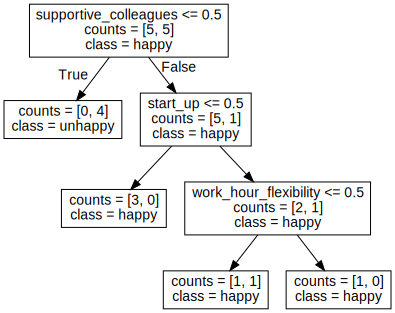

In [9]:
def display_tree(feature_names, tree, counts=False):
    """For binary classification only"""
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    # dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    if counts:
        dot = re.sub("(samples = [0-9]+)\\\\n", "", dot)
        dot = re.sub("value", "counts", dot)
    else:
        dot = re.sub(
            "(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])", "", dot
        )
        dot = re.sub(
            "(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot
        )

    return graphviz.Source(dot)

display_tree(feature_names=["supportive_colleagues", "work_hour_flexibility", "start_up"],
            tree=toy_tree,
            counts=True)

The depth of learned model for toy_tree is 3.

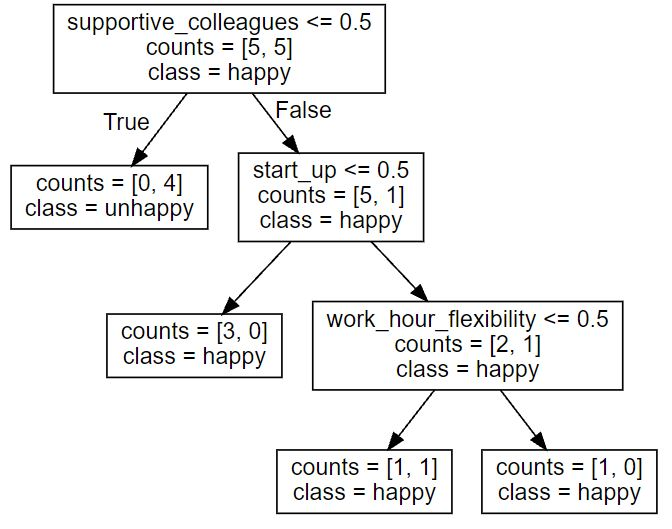

In [10]:
Image('tree.jpg')

<br><br>

### 1.5 Accuracy on the training data
rubric={reasoning:4}

**Your tasks:**

Evaluate the `toy_tree` (call `score()`) on the training data (i.e., `X` and `y`). Do you get perfect training accuracy? Why or why not? 

In [11]:
toy_tree.score(X, y)

0.9

The reason we are not getting a perfect train accuracy of 1 is that on the very last leaf of the three we get a 1-happy, 1-unhappy count on the split. This means that we have not been able to perfectly separate the happy target from unhappy using our current features and might need extra features to do so.

<br><br>

### 1.6 Predicting on the offer data 
rubric={reasoning:3}

**Your tasks:**

Now `predict` on `offer_df`. In which job you are likely to be happy? 

In [12]:
toy_tree.predict(offer_df)

array(['happy', 'unhappy', 'unhappy'], dtype=object)

I am likely to be happy in the first job.

<br><br><br><br>

## Exercise 2: Decision trees on Spotify Song Attributes dataset <a name="2"></a>
<hr>

### Introducing the dataset
  
For the rest of the lab you'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

> You will not be able to push it to your repository (hopefully) because I have seeded the repository wich `.gitignore`.

### 2.1 Reading the data CSV
rubric={accuracy:3}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index.

In [13]:
spotify_df = pd.read_csv("spotify.csv", index_col=0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


<br><br>

### 2.2 Data splitting 
rubric={accuracy:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [14]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)
test_df.shape

(404, 16)

1613 train examples and 404 test examples.

<br><br>

### 2.3 `describe` and `info`
rubric={accuracy:5}

**Your tasks:**

1. Show output of `info()` on the **training split**. 
2. Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
3. Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.


> Note that `describe` returns another DataFrame.

**speechiness is the feature with the smallest range.**

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 1505 to 1534
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      1613 non-null   float64
 1   danceability      1613 non-null   float64
 2   duration_ms       1613 non-null   int64  
 3   energy            1613 non-null   float64
 4   instrumentalness  1613 non-null   float64
 5   key               1613 non-null   int64  
 6   liveness          1613 non-null   float64
 7   loudness          1613 non-null   float64
 8   mode              1613 non-null   int64  
 9   speechiness       1613 non-null   float64
 10  tempo             1613 non-null   float64
 11  time_signature    1613 non-null   float64
 12  valence           1613 non-null   float64
 13  target            1613 non-null   int64  
 14  song_title        1613 non-null   object 
 15  artist            1613 non-null   object 
dtypes: float64(10), int64(4), object(2)
mem

In [16]:
train_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [17]:
train_df.describe().loc["max"] - train_df.describe().loc["min"]

acousticness             0.994995
danceability             0.862000
duration_ms         833918.000000
energy                   0.982200
instrumentalness         0.976000
key                     11.000000
liveness                 0.950200
loudness                32.790000
mode                     1.000000
speechiness              0.792900
tempo                  171.472000
time_signature           4.000000
valence                  0.956100
target                   1.000000
dtype: float64

**speechiness is the feature with the smallest range with value of 0.79.**

<br><br>

### 2.4 Plotting histograms 
rubric={viz:5}

The starter code below produces histograms for the `loudness` feature which shows the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples. There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

> Note: I am using pandas plotting here, which I believe you have learned in 511. You'll be learning `altair` for producing prettier plots in the program and you are welcome to use it or any other tool of your choice for plotting here. 

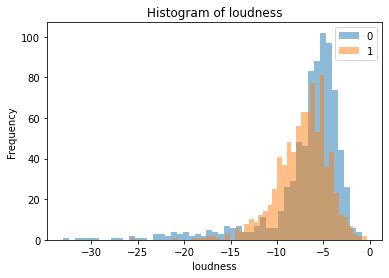

In [18]:
feat = "loudness"
ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
plt.xlabel(feat)
plt.title("Histogram of " + feat)
plt.show()

**Your tasks:**

Create histograms for the following features in the order below.
- acousticness
- danceability
- tempo
- energy
- valence

> To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

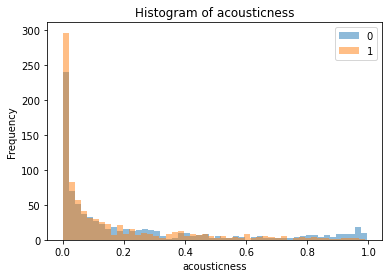

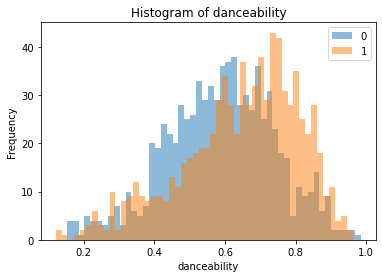

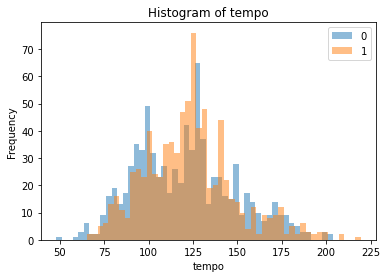

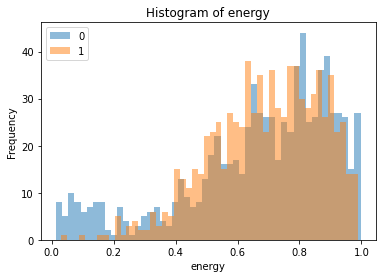

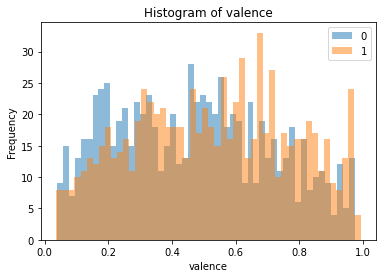

In [19]:
feat_list = ["acousticness", "danceability", "tempo", "energy", "valence"]
for feat in feat_list:
    ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

<br><br>

### 2.5 Decision stump by hand 
rubric={reasoning:3}

**Your tasks:**

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

- A good split would be to predict 0 if danceability is < 0.6 and predict 1 otherwise.

<br><br>

### 2.6 Identical histograms
rubric={reasoning:3}

**Your tasks:**

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?



- That is correct. If the two histograms are identical, it means that we are not getting any useful information (in terms of patterns) from that feature, and therefore, we can ignore it.

<br><br>

### 2.7 Which columns to include? 
rubric={reasoning:4}

**Your tasks:**

Note that the dataset includes two free text features labeled `song_title` and `artist`. Do you think these features could be useful in predicting whether the user liked the song or not? Would there be any difficulty in using them in your model?   

These features will not be useful by itself. There would be some difficulty using these two features in our model as they are neither categories nor numbers. It might be useful to do some transformation on these like counting the number of letters or words in each and see if that would cause any specific pattern to show up (e.g. people liking one-word-title songs better than longer ones.)

<br><br><br><br>

## Exercise 3: Data splitting and model building <a name="3"></a>
<hr>
Recall that in machine learning what we care about is generalization; we want to build models that generalize well on unseen examples. One way to approximate generalization error is by splitting the data into train and test splits, building and tuning the model only using the train split, and carrying out the final assessment on the test split. 

In Exercise 2.2, we used `scikit-learn`'s [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data, which shuffles the data before splitting. In this exercise, we will try to convince ourselves the importance of shuffling before splitting. 

The starter code below creates `X` and `y` for you to use in the following questions. In the exercises below, you'll have to calculate `train` and `test` scores several times. To make it a bit easy for you, I am providing you a function `fit_and_report` below, which fits a model and prints train and test scores. Feel free to use this function in the following exercises. 

In [20]:
X = spotify_df.drop(columns=["song_title", "artist", "target"])
y = spotify_df["target"]

In [21]:
def fit_and_report(model, X_train, y_train, X_test, y_test):
    """
    Fits a given model on the training data and prints train and
    test scores.

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X_train part of the data
    y_train: numpy.ndarray
        The y_train part of the data
    X_test: numpy.ndarray
        The X_train part of the data
    y_test: numpy.ndarray
        The y_test part of the data

    Returns
    -------
        None
    """
    model.fit(X_train, y_train)
    print("Training score: %0.3f" % (model.score(X_train, y_train)))
    print("Test score: %0.3f" % (model.score(X_test, y_test)))

<br><br>

### 3.1 Splitting without shuffling 
rubric={accuracy:4}

The dataset has total 2,017 examples. 

**Your tasks:**  

1. Split `X` and `y` as follows: 
    - Use the first 1500 rows as the train set (`X_train` and `y_train`)
    - Use the remaining rows as the test set (`X_test` and `y_test`)
2. Train `DummyClassifier` on the train set and score it on the train and test sets.
3. Now train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

> You may use the `fit_and_report` function above to `fit` and `score` models.  

> If parameter values are not specified explicitly, you may use the default values. 

In [22]:
X_train = X.iloc[:1500]
y_train = y.iloc[:1500]
X_test = X.iloc[1500:]
y_test = y.iloc[1500:]
y_train

0       1
1       1
2       1
3       1
4       1
       ..
1495    0
1496    0
1497    0
1498    0
1499    0
Name: target, Length: 1500, dtype: int64

In [23]:
# Dummy Classifier
fit_and_report(DummyClassifier(), X_train, y_train, X_test, y_test)

Training score: 0.680
Test score: 0.000


In [24]:
# Decision Tree Classifier
fit_and_report(DecisionTreeClassifier(random_state=123), X_train, y_train, X_test, y_test)

Training score: 0.998
Test score: 0.491


<br><br>

### 3.2 Splitting with shuffling 
rubric={accuracy:4}

The problem in the previous exercise was that we did not shuffle the training examples before splitting. Let's see if shuffling the data improves the test score.

**Your tasks:** 

1. Run the starter code below to shuffle `X` and `y`. 
2. Split the **shuffled data** as follows: 
    - Use the first 1500 rows as the train set 
    - Use the remaining rows as the test set
3. Train `DummyClassifier` on the train set and score it on the train and test sets.    
4. Now train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

In [25]:
X_shuffled = X.reindex(np.random.permutation(X.index))
y_shuffled = y.reindex(X_shuffled.index)

In [26]:
X_train = X_shuffled.iloc[:1500]
y_train = y_shuffled.iloc[:1500]
X_test = X_shuffled.iloc[1500:]
y_test = y_shuffled.iloc[1500:]

In [27]:
# Dummy Classifier
fit_and_report(DummyClassifier(), X_train, y_train, X_test, y_test)

Training score: 0.507
Test score: 0.501


In [28]:
# Decision Tree Classifier
fit_and_report(DecisionTreeClassifier(random_state=123), X_train, y_train, X_test, y_test)

Training score: 0.999
Test score: 0.685


<br><br>

### 3.3 Splitting with `train_test_split` 
rubric={accuracy:4}

**Your tasks:** 

1. Now split the Spotify dataset into a 80% train and 20% test using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`.
2. Train `DummyClassifier` on the train set and score it on the train and test sets.    
3. Train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [30]:
# Dummy Classifier
fit_and_report(DummyClassifier(), X_train, y_train, X_test, y_test)

Training score: 0.508
Test score: 0.498


In [31]:
# Decision Tree Classifier
fit_and_report(DecisionTreeClassifier(random_state=123), X_train, y_train, X_test, y_test)

Training score: 0.999
Test score: 0.688


<br><br>

### 3.4 Discussion
rubric={reasoning:4}

**Your tasks:** 
1. Why do you think we got a lower test accuracy on the Spotify Song Attributes datasets when we did not shuffle the data before splitting compared to when we shuffled the data before splitting?  
2. Do you expect `DummyClassifier` to be sensitive to data shuffling and splitting? Why or why not?     

1. The original data was sorted in a way that target=1 would appear in the beginning and target=0 at the very end. Therefore, the model had seen less of target=0 and was not able to generalize.  
2. Dummy Classifier is extremely sensitive to the data not being shuffled because what it does is to see what target class has a higher ratio and then sets the prediction to that class. Now if one specific class does not have a good representation in the train set, or alternatively, the class with the majority count in train set is absent in the test set (in the case of example above), it won't be able to pick the class with higher ratio.

<br><br>

### 3.5 Cross-validation
rubric={accuracy:4}

**Your tasks:** 

Carry out 10-fold cross validation using `cross_validate` on `X_train` and `y_train` from Exercise 3.3 by passing `return_train_score=True`. Display the results as a pandas dataframe. 

In [32]:
cv_results = pd.DataFrame(cross_validate(DecisionTreeClassifier(random_state=123), X_train, y_train, cv=10, return_train_score=True))
cv_results

,fit_time,score_time,test_score,train_score
0,0.017746,0.003033,0.722222,0.999311
1,0.016707,0.001044,0.660494,1.000000
2,0.015584,0.002041,0.660494,0.999311
3,0.014006,0.001993,0.677019,1.000000
4,0.002054,0.000000,0.695652,0.999311
5,0.015669,0.000000,0.652174,0.999311
6,0.015626,0.015621,0.658385,0.999311
7,0.015835,0.002037,0.608696,0.999311
8,0.014006,0.000992,0.683230,0.999311
9,0.000000,0.015664,0.695652,0.999311


In [33]:
cv_results.mean()

fit_time       0.012723
score_time     0.004243
test_score     0.671402
train_score    0.999449
dtype: float64

<br><br>

### 3.6 Examining cross-validation scores
rubric={reasoning:5}

**Your tasks:** 
1. Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your mean cross-validation score?
2. Do you see a significant difference between the training scores and the cross-validation scores? Briefly discuss in 1 to 2 sentences. 

1. Except for one outlier, the remaining cross validation sub-scores are close to 0.70 which is similar to the mean of cross validation sub-scores. This shows that this value (mean) could be a trustworthy representation of the score.  
2. Yes. The significant difference between training and CV sub-scores are mainly due to the fact that our models are overfitting in each iteration which causes them not being able to generalize well, and therefore, giving lower CV sub-scores.

<br><br><br><br>

## Exercise 4: Hyperparameters <a name="4"></a>
<hr>

### 4.1 Train and cross-validation plots
rubric={accuracy:12}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

**Your tasks:**

1. Just to start fresh, split the Spotify dataset into a 80% train and 20% test subset using [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and `random_state=123`.
2. Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25). 
3. For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
4. Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.

> You may use whatever tool you like for plotting. We also have done something similar in lecture 2, and you may adapt that code to answer this question. 

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

In [34]:
X = spotify_df.drop(["target", "song_title", "artist"], axis=1)
y = spotify_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [35]:
results_tbl = pd.DataFrame()

for i in range(1,26):
    results = cross_validate(DecisionTreeClassifier(random_state=123, max_depth=i), X_train, y_train, cv=10, return_train_score=True)
    results_tbl = pd.concat([results_tbl, pd.DataFrame(results).mean()], axis=1)
results_tbl = results_tbl.T
results_tbl["max_depth"] = range(1,26)
results_tbl.rename(columns={"test_score" : "CV Score", "train_score" : "Train Score"}, inplace=True)
results_tbl.head()

,fit_time,score_time,CV Score,Train Score,max_depth
0,0.004205,0.001406,0.642926,0.650686,1
0,0.007817,0.000000,0.692520,0.711718,2
0,0.006030,0.000497,0.693766,0.732797,3
0,0.006257,0.001562,0.723522,0.768066,4
0,0.006252,0.001562,0.711705,0.793346,5


In [36]:
reshaped_results = results_tbl.drop(["fit_time", "score_time"], axis=1).melt("max_depth")

alt.Chart(reshaped_results).mark_line().encode(
    x = "max_depth",
    y = "value",
    color = "variable"
)

alt.Chart(...)

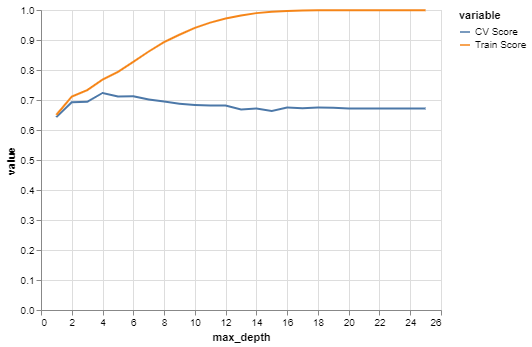

In [37]:
Image('cv_test_viz.png')

<br><br>

### 4.2 `max_depth` and the fundamental tradeoff
rubric={reasoning:2}

**Your tasks:**
1. Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. 

With increasing the max_depth from 1 we see an initial improvement in cross-validation accuracy, but this accuracy drops after max_depth=4 showing traits of overfitting.

<br><br>

### 4.3 Picking the best value for `max_depth`
rubric={reasoning:3}

**Your tasks:**
1. From these results, what value for `max_depth` would you pick as the optimal value? 

max_depth of 4 would be the optimal value according to the plot above.

<br><br>

### 4.4 Final assessment on the test split 
rubric={accuracy:3}

1. Train a decision tree classifier using the optimal `max_depth` you chose in the previous exercise on the _entire training set_.
2. Compute and display the test score. 

In [38]:
dt_model = DecisionTreeClassifier(max_depth=4, random_state=123)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.6782178217821783

<br><br>

### 4.5 Analysis
rubric={reasoning:5}

1. How do the test scores compare to the cross-validation scores? Briefly discuss. 
2. Why can't you simply pick the value of `max_depth` that gives the best accuracy on the training data? (Answer in maximum 2 to 3 sentences.)
3. Do you think that the `max_depth` you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

1. The test score (0.68) is very close to the mean cross validation score (0.70) but smaller which shows that our model has been able to generalize well give the max_depth we used for the model.  
2. This is mainly due to the issue of overfitting. As the complexity of our model grows in order to predict our train target perfectly, that model will only be trained to recognize the specific patterns within the train data it is given. This model will then not be able to generalize well and deal with the test data (and after that deployment data).  
3. It will generalize well on the population that this sample was pulled from. However, an accuracy of 0.70 is not a high score and we could use other classification models to get better predictions with higher scores.

<br><br><br><br>

## (Optional) Exercise 5
<hr>

Each lab is likely to have a few optional questions. In some of the labs I will be including an optional question which leads to the material in the upcoming week. These are usually a low-risk question and are worth very few points. The intention here is not to get the perfect answer from you but to get you thinking about the upcoming material.

### (Optional) 5.1 Exploring datasets and features
rubric={reasoning:1}

In the previous exercise you systematically searched for a model that is likely to generalize well using cross-validation. 

1. Does this model use all the features provided to it? Which features seem most important? Does this match with what you observed in the exploratory data analysis? 
2. Note that *acousticness* and *duration_ms* features are on a completely different scale. Does it matter when we learn a `DecisionTreeClassifier`?
3. Suppose you believe that *artist* is a useful feature in this task. How would you encode it in order to use it with `sklearn`? 

<br><br>

### (Optional) 5.2 Exploring datasets and features
rubric={reasoning:1}

For each of the supervised machine learning problems listed below: 

- Flagging fraud transactions. 
- Getting sense of audiences' sentiment on a newly released movie or a product.
- Housing price predicting in Vancouver. 

Answer the following questions: 

1. List 4 to 8 features which could be useful to solve the problem. 
2. Find dataset(s) which could be useful to answer the question you are interested in answering. Here are some places you can look for datasets: [Kaggle](https://www.kaggle.com/), [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 
3. Comment on the quality/limitations of the dataset.  
4. Would it be worth collecting more data to answer your question better? 

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. 

### Congratulations on finishing lab 1! Well done 👏👏! 